# Problem setup

we will solve SEIR model with following parameter using PINN.

Population : 100,000 \
Pre-infectious period : 8 days \
infectious period : 7 days \
R0 : 13 \
Initial value : (S,E,I,R) = (99999 ,0 ,1 ,0)



 


$$\left\{
\begin{array}{ll}
\ dSdt = - \lambda * S   \\
\ dEdt =   \lambda * S  - f * E \\
\ dIdt =   f * E - r * I\\
\ dRdt =   r * I
\end{array}
\right.
$$

where $ \lambda = beta * I $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pandas as pd
from IPython.display import clear_output
import urllib.request
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)
    

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
#download the dataset

url = "https://raw.githubusercontent.com/abhisoni24/seir-pinn-hybrid/refs/heads/main/SEIR-PINN/KOR.csv"

filename = "KOR.csv"
urllib.request.urlretrieve(url, filename)   

('KOR.csv', <http.client.HTTPMessage at 0x24e5d3fccd0>)

In [3]:
#data post-processing

data = pd.read_csv(filename)

#remove rows with NaN values in specific columns
data = data.dropna(subset=['date','confirmed', 'deaths', 'recovered'])

#convert date to datetime and calculate days since the first date
data['date'] = pd.to_datetime(data['date'])
data['days'] = (data['date'] - data['date'].min()).dt.days

days = data['days'].values
confirmed = data['confirmed'].values
deaths = data['deaths'].values
recovered = data['recovered'].values
population = data['population'].values[0]

data['infectious']  = data['confirmed'] - data['deaths'] - data['recovered']
infectious = data['infectious'].values      #current shape = (561,)


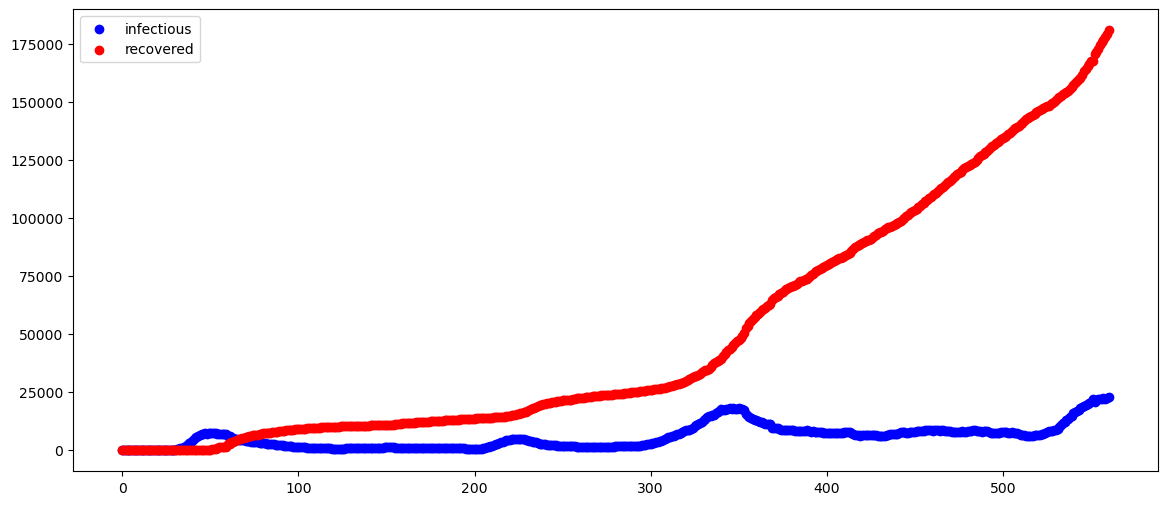

In [4]:
#see how data looks like

plt.figure(figsize=(14,6))

#plt.subplot(1,2,1)
plt.scatter(days,infectious, color ='blue' ,marker ='o',label = 'infectious')
plt.scatter(days,recovered,  color ='red'  ,marker ='o',label = 'recovered')

plt.legend()
plt.show()

In [5]:
#data normalization
t_max = days.max()
days_norm = days / t_max

#PINN collocation points
t_collocation = np.linspace(0, 1, 1000,dtype=np.float32)[:,None] # make sure it's a 2D array : [1000,1]

scaler_S = MinMaxScaler()           # if there exist outliers, use RobustScaler
scaler_E = MinMaxScaler()
scaler_I = MinMaxScaler()
scaler_R = MinMaxScaler()

I_scaled = scaler_I.fit_transform(infectious.reshape(-1, 1))  # scale input to 0-1
R_scaled = scaler_R.fit_transform((recovered+deaths).reshape(-1, 1))  


#for S, we assume the initial susceptible population is the total population minus the first infectious case
S_initial = population - confirmed[0]
S_final = population - confirmed[-1]
scaler_S.fit(np.array([S_initial, S_final]).reshape(-1,1))   # 'fit' Compute the minimum and maximum to be used for later scaling.

#for #, assume reasonable range
scaler_E.fit(np.array([0, confirmed.max()*0.1]).reshape(-1,1))  # 'fit' Compute the minimum and maximum to be used for later scaling.


X_data = days_norm.reshape(-1, 1).astype(np.float32) 
y_data_I = I_scaled
y_data_R = R_scaled



In [6]:
#NN

class SEIR(nn.Module):
    def __init__(self, hidden_dim):
        super(SEIR, self).__init__()
        
        self.layers = []
        for i in range(len(hidden_dim) - 1):
            self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            #nn.init.zeros_(layer.bias)
        
        self.act = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        x = self.layers[-1](x)  # Last layer without activation
        return x

net = SEIR([1,64,64,4]).to(device)

In [7]:
#initial condition
S0_scaled = scaler_S.transform(np.array([population-confirmed[0]]).reshape(-1, 1))  #transfrom according to fit
E0_scaled = np.array([0.0]) #we dont know, assume 0 for now
I0_scaled = np.array([I_scaled[0,0]])
R0_scaled = np.array([R_scaled[0,0]])
print(S0_scaled)


#beta = torch.FloatTensor([[0.5]]).requires_grad_(True).to(device)  #check shape later if error occur current shape = (1,1)
beta = torch.FloatTensor([[0.5]]).to(device).requires_grad_(True)
sigma = torch.FloatTensor([[0.2]]).to(device).requires_grad_(True)
gamma = torch.FloatTensor([[0.1]]).to(device).requires_grad_(True)

beta.is_leaf

[[1.]]


True

In [8]:
def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True,grad_outputs=torch.ones(y.size()).to(device))[0]

def seir_model(t):
    t = t.requires_grad_(True).to(device)
    y = net(t)  # Forward pass through the network
    S, E, I, R = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    
    dSdt = derivative(S, t)
    dEdt = derivative(E, t)
    dIdt = derivative(I, t)
    dRdt = derivative(R, t)
    return S, E, I, R, dSdt, dEdt, dIdt, dRdt

In [9]:
def compute_loss():
    loss_f = nn.MSELoss()
    # Forward pass through the network
    S, E, I, R, dSdt, dEdt, dIdt, dRdt = seir_model(torch.FloatTensor(t_collocation).to(device))

    S = S.view(-1,1)
    E = E.view(-1,1)
    I = I.view(-1,1)
    R = R.view(-1,1)
    N = torch.FloatTensor([[1.0]]).to(device)
    
    #phy loss
    dSdt_phy = -beta * S * I / N
    dEdt_phy = beta * S * I / N - sigma * E
    dIdt_phy = sigma * E - gamma * I
    dRdt_phy = gamma * I

    S_loss = loss_f(dSdt - dSdt_phy, torch.zeros_like(dSdt))
    E_loss = loss_f(dEdt - dEdt_phy, torch.zeros_like(dEdt))
    I_loss = loss_f(dIdt - dIdt_phy, torch.zeros_like(dIdt))
    R_loss = loss_f(dRdt - dRdt_phy, torch.zeros_like(dRdt))


    #data loss
    X_data_ = torch.from_numpy(X_data)
    _, _, I_pred, R_pred, _, _, _, _ = seir_model(X_data_)
    I_pred = I_pred.view(-1,1)
    R_pred = R_pred.view(-1,1)

    I_data_loss = loss_f(I_pred - torch.FloatTensor(y_data_I).to(device), torch.zeros_like(I_pred))
    R_data_loss = loss_f(R_pred - torch.FloatTensor(y_data_R).to(device), torch.zeros_like(R_pred))

    


    #IC loss

    S0_pred, E0_pred, I0_pred, R0_pred, _, _, _, _ = seir_model(torch.FloatTensor([[0.0]]))
    S0_pred = S0_pred.view(-1,1)
    E0_pred = E0_pred.view(-1,1)
    I0_pred = I0_pred.view(-1,1)
    R0_pred = R0_pred.view(-1,1)

    S0_loss = loss_f(S0_pred - torch.FloatTensor(S0_scaled).to(device), torch.zeros_like(S0_pred))
    E0_loss = loss_f(E0_pred -  torch.FloatTensor(E0_scaled).to(device), torch.zeros_like(E0_pred))
    I0_loss = loss_f(I0_pred -  torch.FloatTensor(I0_scaled).to(device), torch.zeros_like(I0_pred))
    R0_loss = loss_f(R0_pred -  torch.FloatTensor(R0_scaled).to(device), torch.zeros_like(R0_pred))

    #conservation of mass
    # S + E + I + R = N
    con_loss = loss_f(S + E + I + R, torch.ones_like(S))

    weight_phy = 1.0
    weight_data = 10.0
    weight_ic = 10.0
    weight_con = 5.0
    

    loss = (S_loss + E_loss + I_loss +  R_loss) * weight_phy + (R_data_loss + I_data_loss) * weight_data + (S0_loss + E0_loss + I0_loss + R0_loss) * weight_ic + con_loss * weight_con

    return loss


In [10]:
optimizer = torch.optim.Adam([{'params': net.parameters()},{'params': beta, 'lr':3e-3}, {'params': sigma, 'lr':1e-1}, {'params': gamma, 'lr':1e-1}], lr=1e-3)

epochs = 10000
print_every = 1000
history = {'loss' : [],
              'beta' : [], 
              'sigma' : [],
              'gamma' : []}

In [11]:
for i in range(epochs): 

    optimizer.zero_grad()   # reset gradient that used in optimizer to zero after one iteration.  (model.zero_grad() resets all parameter in model)
    loss = compute_loss()
    loss.backward()
    optimizer.step()

    history['loss'].append(loss.item())
    history['beta'].append(beta.item())
    history['sigma'].append(sigma.item())
    history['gamma'].append(gamma.item())


    if not i % 1000:
        print(f"epoch: {i+1}/{epochs}, loss: {loss.item():.4f}, beta: {beta.item():.4f}, sigma: {sigma.item():.4f}, gamma: {gamma.item():.4f}")



epoch: 1/10000, loss: 45.0499, beta: 0.5030, sigma: 0.1000, gamma: 0.2000


KeyboardInterrupt: 

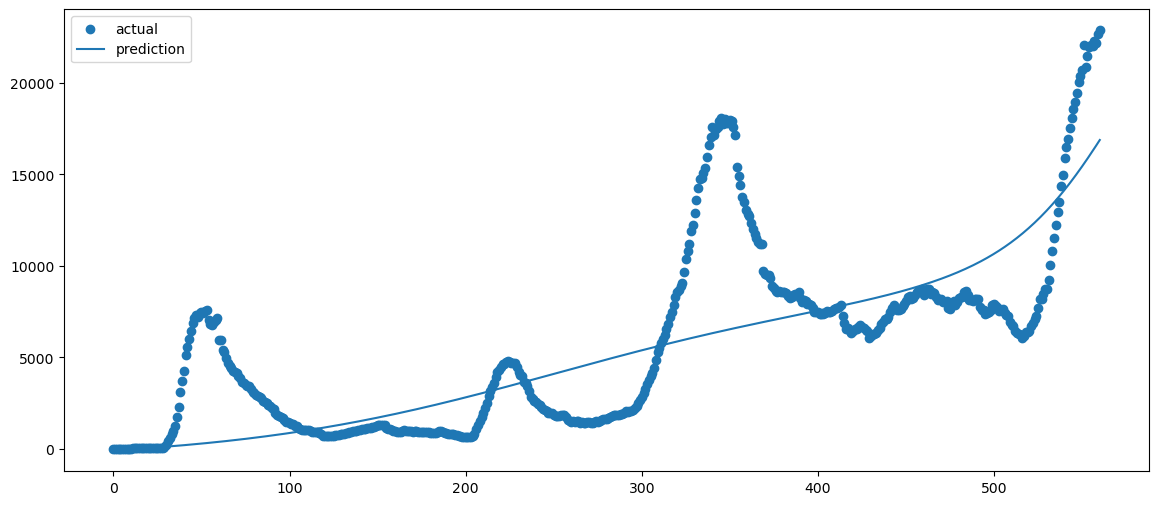

In [ ]:
t_pred = torch.linspace(0,1,500).view(-1,1)

S_pred, E_pred, I_pred, R_pred, _, _,_,_ = seir_model(t_pred)

S_pred_orig = scaler_S.inverse_transform(S_pred.detach().cpu().reshape(-1,1))
E_pred_orig = scaler_E.inverse_transform(E_pred.detach().cpu().reshape(-1,1))
I_pred_orig = scaler_I.inverse_transform(I_pred.detach().cpu().reshape(-1,1))
R_pred_orig = scaler_R.inverse_transform(R_pred.detach().cpu().reshape(-1,1))

t_orig = torch.linspace(0,t_max,500)

plt.figure(figsize=(14,6))

#plt.subplot(1,2,1)
plt.scatter(days,infectious,marker ='o',label = 'actual')
plt.plot(t_orig, I_pred_orig ,label = 'prediction')
plt.legend()
plt.show()